In [1]:
import os
from dotenv import load_dotenv
import asyncpg
import pandas as pd

load_dotenv('.env.notebook.local')

DATABASE_URL = os.getenv('DATABASE_URL')

conn = await asyncpg.connect(DATABASE_URL)

row = await conn.fetchrow("SELECT current_database(), current_user, version()")
print(f"Database: {row[0]}")
print(f"User: {row[1]}")
print(f"Version: {row[2][:50]}...")

count = await conn.fetchval("SELECT COUNT(*) FROM posts")
print(f"\nTotal posts in database: {count}")

await conn.close()

Database: neondb
User: readonly_user1
Version: PostgreSQL 17.5 (6bc9ef8) on aarch64-unknown-linux...

Total posts in database: 10794


In [2]:
# Domain Classification Summary
import json

conn = await asyncpg.connect(DATABASE_URL)

# Get domain labels from classifier schema
classifier_row = await conn.fetchrow("""
    SELECT output_schema 
    FROM classifiers 
    WHERE slug = 'domain-classifier-v1'
""")
output_schema = json.loads(classifier_row['output_schema']) if isinstance(classifier_row['output_schema'], str) else classifier_row['output_schema']
domain_lookup = {
    choice['value']: choice['label'] 
    for choice in output_schema['choices']
}

sql = """
WITH domain_counts AS (
    SELECT 
        jsonb_array_elements(classification_data->'values')->>'value' as domain,
        COUNT(*) as post_count
    FROM classifications
    WHERE classifier_slug = 'domain-classifier-v1'
    GROUP BY domain
),
total_posts AS (
    SELECT COUNT(DISTINCT post_uid) as total
    FROM classifications
    WHERE classifier_slug = 'domain-classifier-v1'
)
SELECT 
    dc.domain,
    dc.post_count,
    ROUND(100.0 * dc.post_count / tp.total, 2) as percent
FROM domain_counts dc
CROSS JOIN total_posts tp
ORDER BY dc.post_count DESC
"""

rows = await conn.fetch(sql)
df = pd.DataFrame(rows, columns=['domain', 'post_count', 'percent'])
df['domain_label'] = df['domain'].map(domain_lookup)
df = df[['domain_label', 'post_count', 'percent']]

print(f"Total classified posts: {df['post_count'].sum()}")
print(f"\nDomain Distribution:")
df

Total classified posts: 24768

Domain Distribution:


,domain_label,post_count,percent
0,Politics & Government,5159,48.08
1,Recent News,4533,42.25
2,Media & Attribution,3948,36.79
3,Crime & Safety,2927,27.28
4,Law & Regulation,1826,17.02
5,No Claim,1692,15.77
6,Economy & Business,989,9.22
7,History,755,7.04
8,Culture & Entertainment,691,6.44
9,Health & Medicine,549,5.12


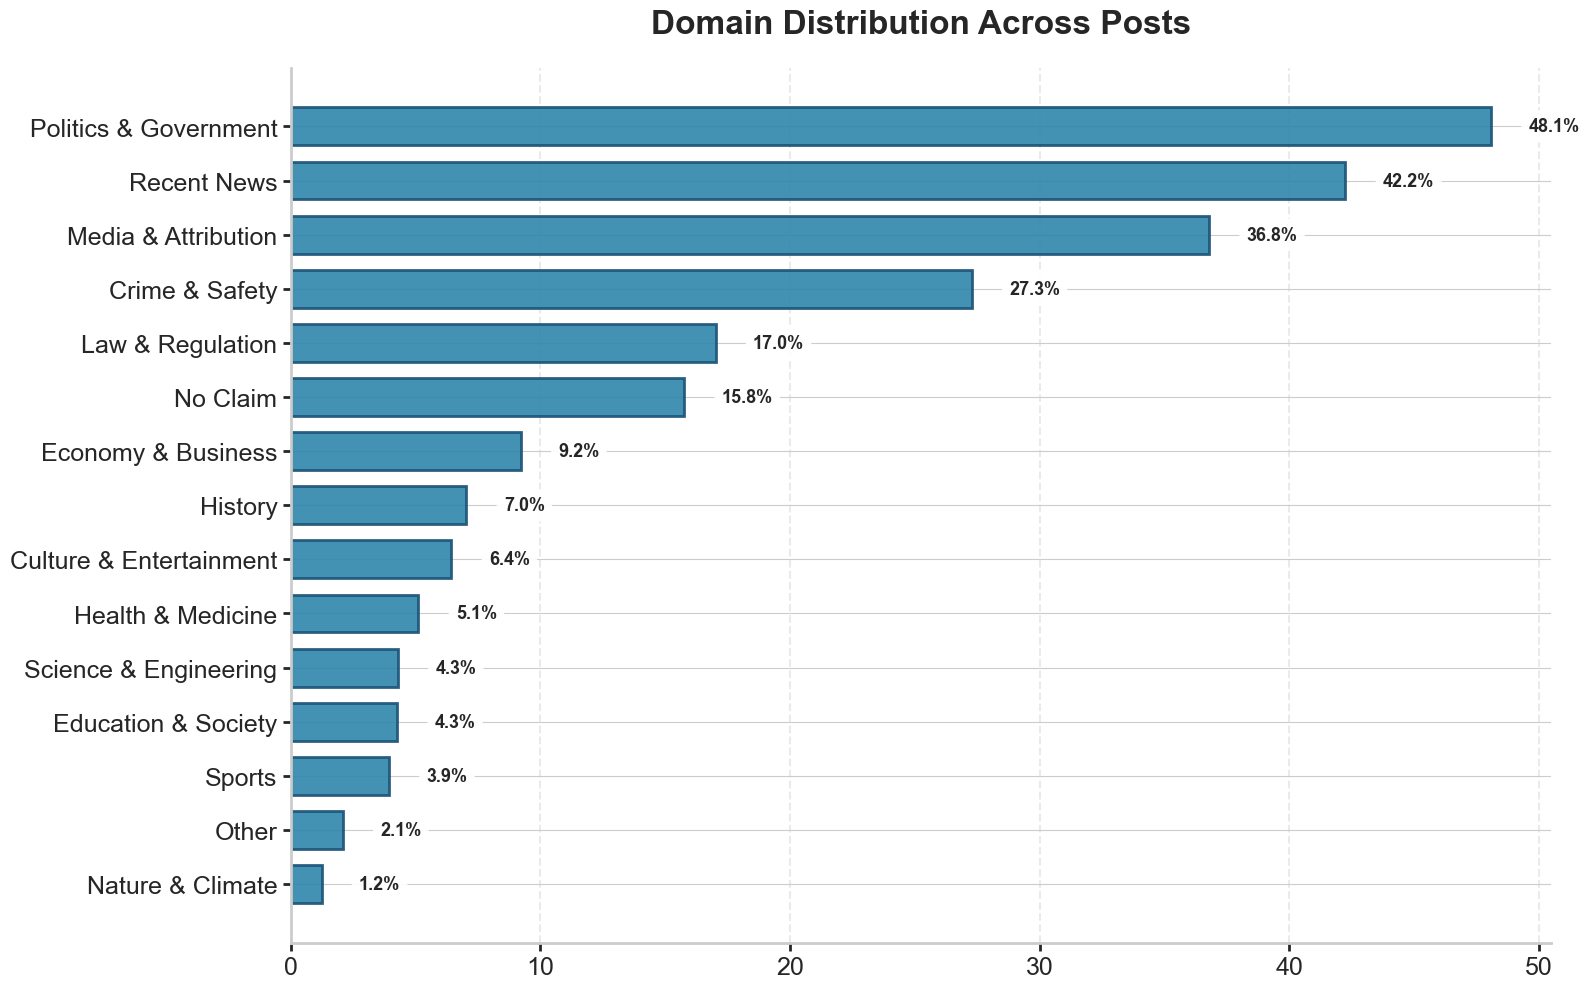

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 10))

# Use a professional color palette
color = '#2E86AB'
bars = ax.barh(df['domain_label'], df['percent'].astype(float), 
               color=color, edgecolor='#1A5276', linewidth=2, alpha=0.9, height=0.7)

#ax.set_xlabel('', fontsize=18, fontweight='bold', labelpad=15)
#ax.set_ylabel('', fontsize=18, fontweight='bold', labelpad=15)
ax.set_title('Domain Distribution Across Posts', fontsize=24, fontweight='bold', pad=25)
ax.tick_params(axis='both', labelsize=18, width=2, length=6)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.4, linestyle='--', linewidth=1.5)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + 1.5, bar.get_y() + bar.get_height()/2, 
            f'{width:.1f}%', ha='left', va='center', 
            fontsize=13, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='none', alpha=0.95))

plt.tight_layout()
plt.show()

In [4]:
# Clarity Classification Summary
import json
import re

conn = await asyncpg.connect(DATABASE_URL)

classifier_row = await conn.fetchrow("""
    SELECT output_schema 
    FROM classifiers 
    WHERE slug = 'clarity-v1'
""")
output_schema = json.loads(classifier_row['output_schema']) if isinstance(classifier_row['output_schema'], str) else classifier_row['output_schema']

clarity_lookup = {
    choice['value']: re.sub(r'\s*\(\d+\)$', '', choice['label']).replace(' ', '\n')
    for choice in output_schema['choices']
}

sql = """
WITH clarity_counts AS (
    SELECT 
        classification_data->>'value' as clarity,
        COUNT(*) as post_count
    FROM classifications
    WHERE classifier_slug = 'clarity-v1'
    GROUP BY clarity
),
total_posts AS (
    SELECT COUNT(DISTINCT post_uid) as total
    FROM classifications
    WHERE classifier_slug = 'clarity-v1'
)
SELECT 
    cc.clarity,
    cc.post_count,
    ROUND(100.0 * cc.post_count / tp.total, 2) as percent
FROM clarity_counts cc
CROSS JOIN total_posts tp
ORDER BY cc.clarity
"""

rows = await conn.fetch(sql)
df_clarity = pd.DataFrame(rows, columns=['clarity', 'post_count', 'percent'])
df_clarity['clarity_label'] = df_clarity['clarity'].map(clarity_lookup)

print(f"Total classified posts: {df_clarity['post_count'].sum()}")
print(f"\nClarity Distribution:")
df_clarity[['clarity_label', 'post_count', 'percent']]

Total classified posts: 9484

Clarity Distribution:


,clarity_label,post_count,percent
0,Very\nUnclear,784,8.27
1,Unclear,1661,17.51
2,Moderate,2709,28.56
3,Clear,3544,37.37
4,Very\nClear,786,8.29


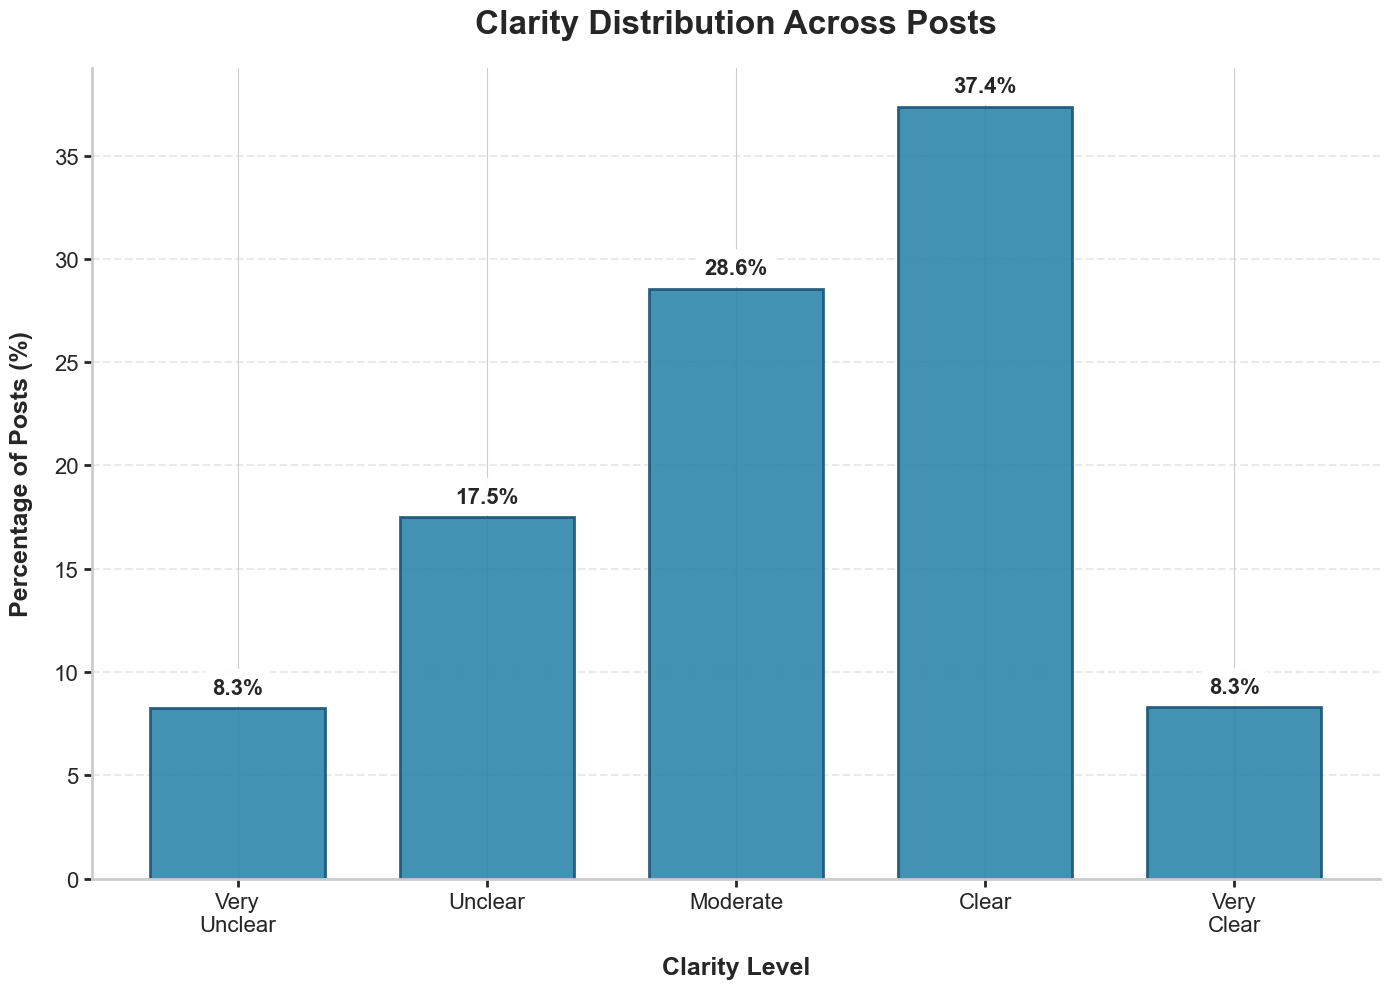

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 10))

# Use consistent color
color = '#2E86AB'
bars = ax.bar(df_clarity['clarity_label'], df_clarity['percent'].astype(float), 
              color=color, edgecolor='#1A5276', linewidth=2, alpha=0.9, width=0.7)

ax.set_ylabel('Percentage of Posts (%)', fontsize=18, fontweight='bold', labelpad=15)
ax.set_xlabel('Clarity Level', fontsize=18, fontweight='bold', labelpad=15)
ax.set_title('Clarity Distribution Across Posts', fontsize=24, fontweight='bold', pad=25)
ax.tick_params(axis='both', labelsize=16, width=2, length=6)
ax.grid(axis='y', alpha=0.4, linestyle='--', linewidth=1.5)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, 
            f'{height:.1f}%', ha='center', va='bottom', 
            fontsize=16, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='none', alpha=0.95))

plt.tight_layout()
plt.show()

In [6]:
# Partisan Tilt Classification Summary
import json

conn = await asyncpg.connect(DATABASE_URL)

classifier_row = await conn.fetchrow("""
    SELECT output_schema 
    FROM classifiers 
    WHERE slug = 'partisan-tilt-v1'
""")
output_schema = json.loads(classifier_row['output_schema']) if isinstance(classifier_row['output_schema'], str) else classifier_row['output_schema']

tilt_lookup = {choice['value']: choice['label'] for choice in output_schema['choices']}

sql = """
WITH tilt_counts AS (
    SELECT 
        classification_data->>'value' as tilt,
        COUNT(*) as post_count
    FROM classifications
    WHERE classifier_slug = 'partisan-tilt-v1'
    GROUP BY tilt
),
total_posts AS (
    SELECT COUNT(DISTINCT post_uid) as total
    FROM classifications
    WHERE classifier_slug = 'partisan-tilt-v1'
)
SELECT 
    tc.tilt,
    tc.post_count,
    ROUND(100.0 * tc.post_count / tp.total, 2) as percent
FROM tilt_counts tc
CROSS JOIN total_posts tp
ORDER BY 
    CASE tc.tilt 
        WHEN 'left_leaning' THEN 1
        WHEN 'center' THEN 2
        WHEN 'right_leaning' THEN 3
    END
"""

rows = await conn.fetch(sql)
df_tilt = pd.DataFrame(rows, columns=['tilt', 'post_count', 'percent'])
df_tilt['tilt_label'] = df_tilt['tilt'].map(tilt_lookup)

print(f"Total classified posts: {df_tilt['post_count'].sum()}")
print(f"\nPartisan Tilt Distribution:")
df_tilt[['tilt_label', 'post_count', 'percent']]

Total classified posts: 10762

Partisan Tilt Distribution:


,tilt_label,post_count,percent
0,Left-leaning,3116,28.95
1,Center,4486,41.68
2,Right-leaning,3160,29.36


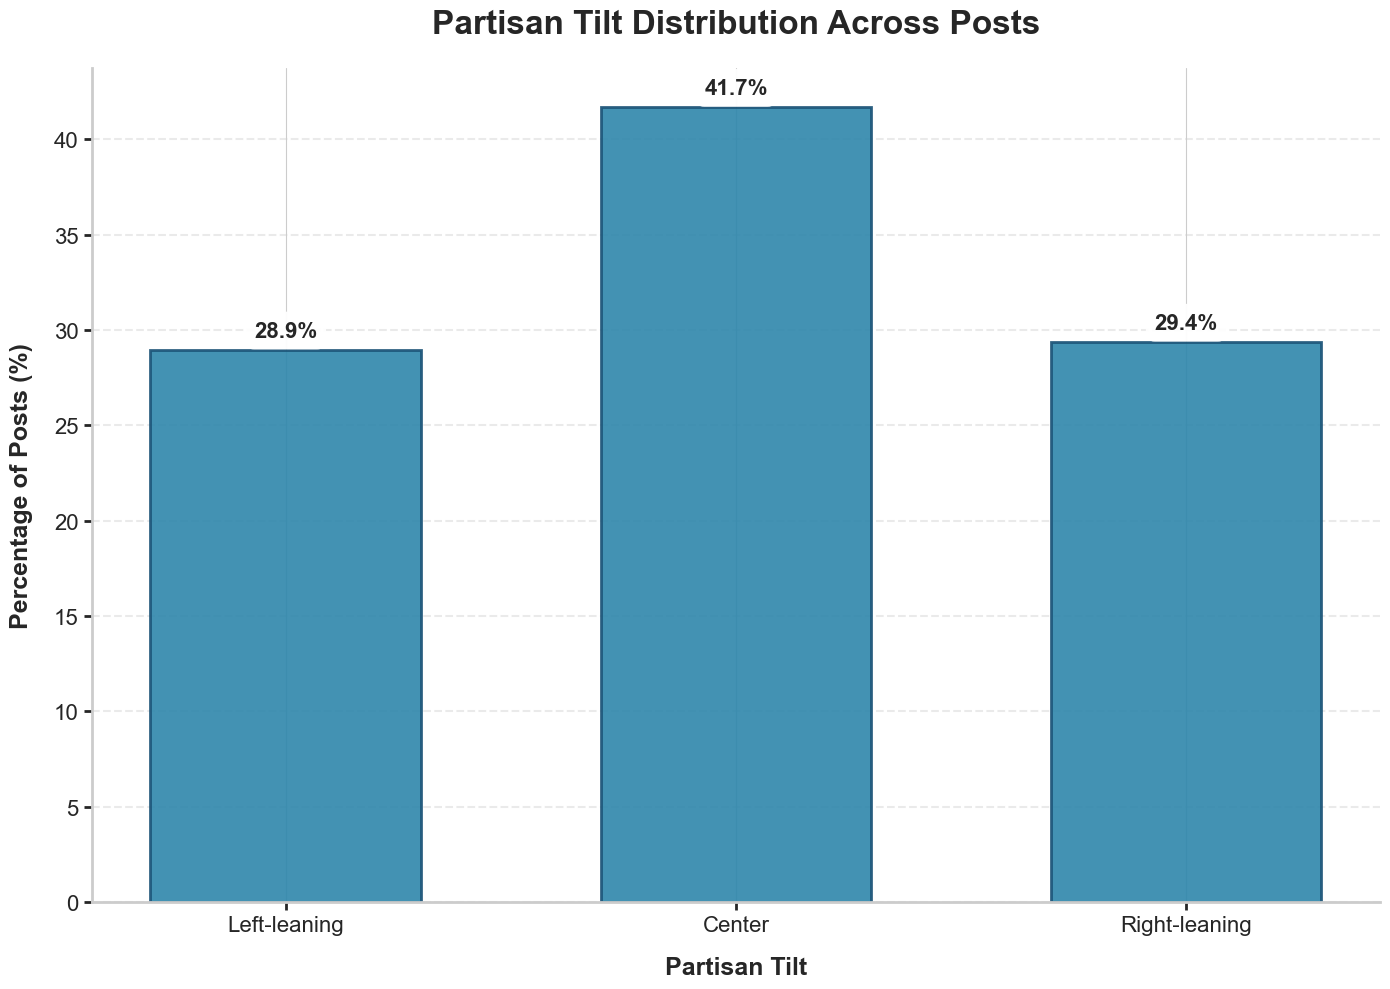

In [7]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 10))

color = '#2E86AB'
bars = ax.bar(df_tilt['tilt_label'], df_tilt['percent'].astype(float), 
              color=color, edgecolor='#1A5276', linewidth=2, alpha=0.9, width=0.6)

ax.set_ylabel('Percentage of Posts (%)', fontsize=18, fontweight='bold', labelpad=15)
ax.set_xlabel('Partisan Tilt', fontsize=18, fontweight='bold', labelpad=15)
ax.set_title('Partisan Tilt Distribution Across Posts', fontsize=24, fontweight='bold', pad=25)
ax.tick_params(axis='both', labelsize=16, width=2, length=6)
ax.grid(axis='y', alpha=0.4, linestyle='--', linewidth=1.5)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, 
            f'{height:.1f}%', ha='center', va='bottom', 
            fontsize=16, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='none', alpha=0.95))

plt.tight_layout()
plt.show()

Total classified posts: 12678

Media Type Distribution:


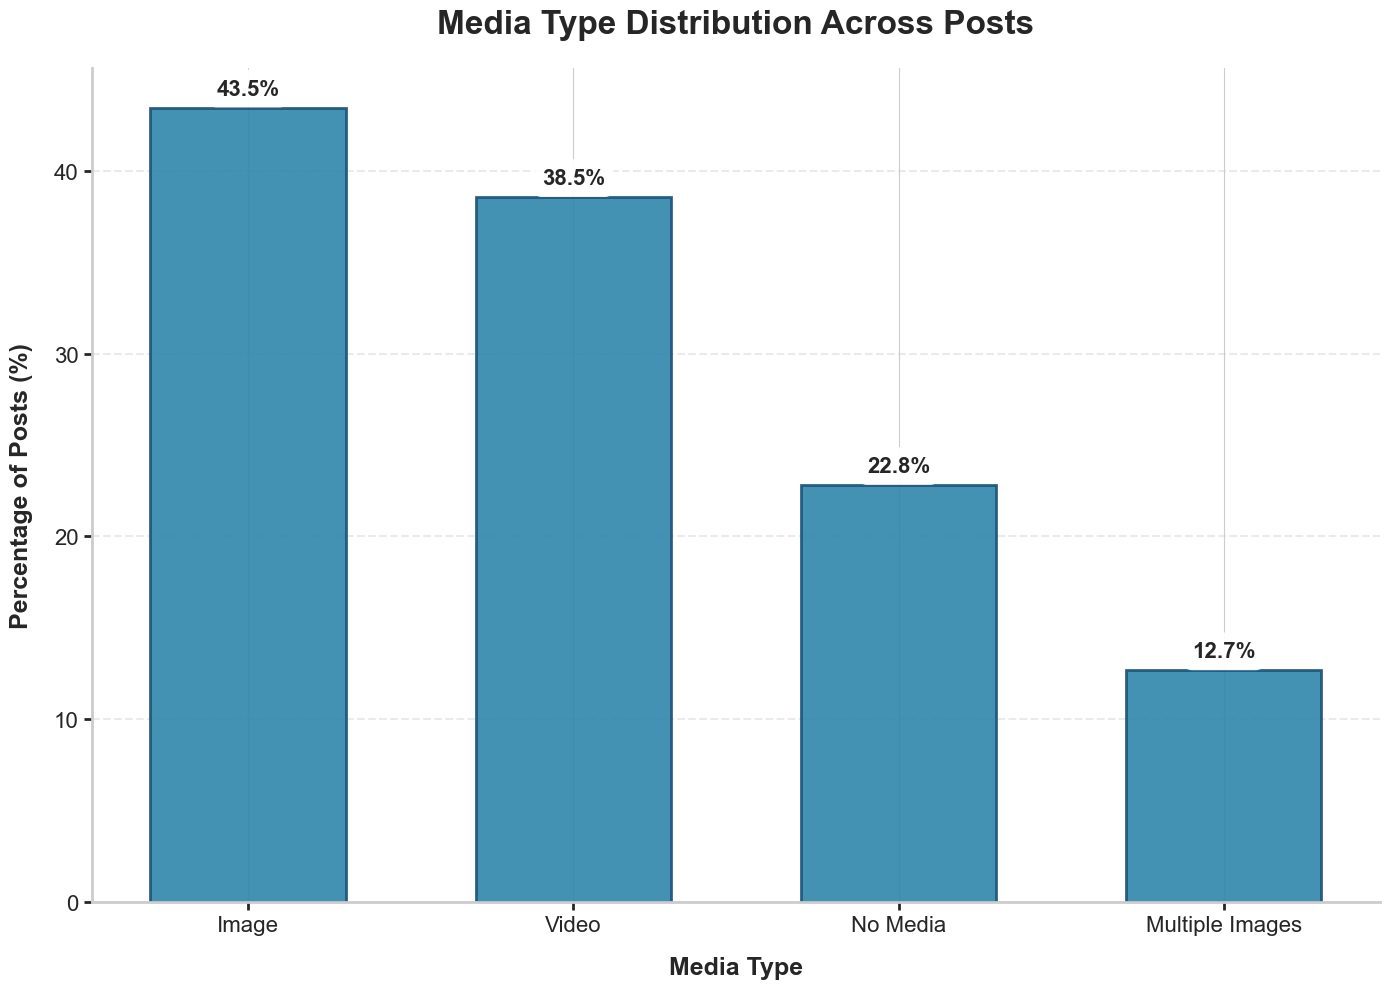

In [8]:
import matplotlib.pyplot as plt
# Media Type Classification Summary
import json

conn = await asyncpg.connect(DATABASE_URL)

sql = """
WITH media_counts AS (
    SELECT 
        jsonb_array_elements(classification_data->'values')->>'value' as media_type,
        COUNT(*) as post_count
    FROM classifications
    WHERE classifier_slug = 'media-type-v1'
    GROUP BY media_type
),
total_posts AS (
    SELECT COUNT(DISTINCT post_uid) as total
    FROM classifications
    WHERE classifier_slug = 'media-type-v1'
)
SELECT 
    mc.media_type,
    mc.post_count,
    ROUND(100.0 * mc.post_count / tp.total, 2) as percent
FROM media_counts mc
CROSS JOIN total_posts tp
WHERE mc.media_type IS NOT NULL
ORDER BY mc.post_count DESC
"""

rows = await conn.fetch(sql)
df_media = pd.DataFrame(rows, columns=['media_type', 'post_count', 'percent'])
df_media['media_label'] = df_media['media_type'].str.replace('has_', '').str.replace('_', ' ').str.title()

print(f"Total classified posts: {df_media['post_count'].sum()}")
print(f"\nMedia Type Distribution:")
df_media[['media_label', 'post_count', 'percent']]

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 10))

color = '#2E86AB'
bars = ax.bar(df_media['media_label'], df_media['percent'].astype(float), 
              color=color, edgecolor='#1A5276', linewidth=2, alpha=0.9, width=0.6)

ax.set_ylabel('Percentage of Posts (%)', fontsize=18, fontweight='bold', labelpad=15)
ax.set_xlabel('Media Type', fontsize=18, fontweight='bold', labelpad=15)
ax.set_title('Media Type Distribution Across Posts', fontsize=24, fontweight='bold', pad=25)
ax.tick_params(axis='both', labelsize=16, width=2, length=6)
ax.grid(axis='y', alpha=0.4, linestyle='--', linewidth=1.5)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, 
            f'{height:.1f}%', ha='center', va='bottom', 
            fontsize=16, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='none', alpha=0.95))

plt.tight_layout()
plt.show()

Total classified posts: 10794

Tweet Type Distribution:


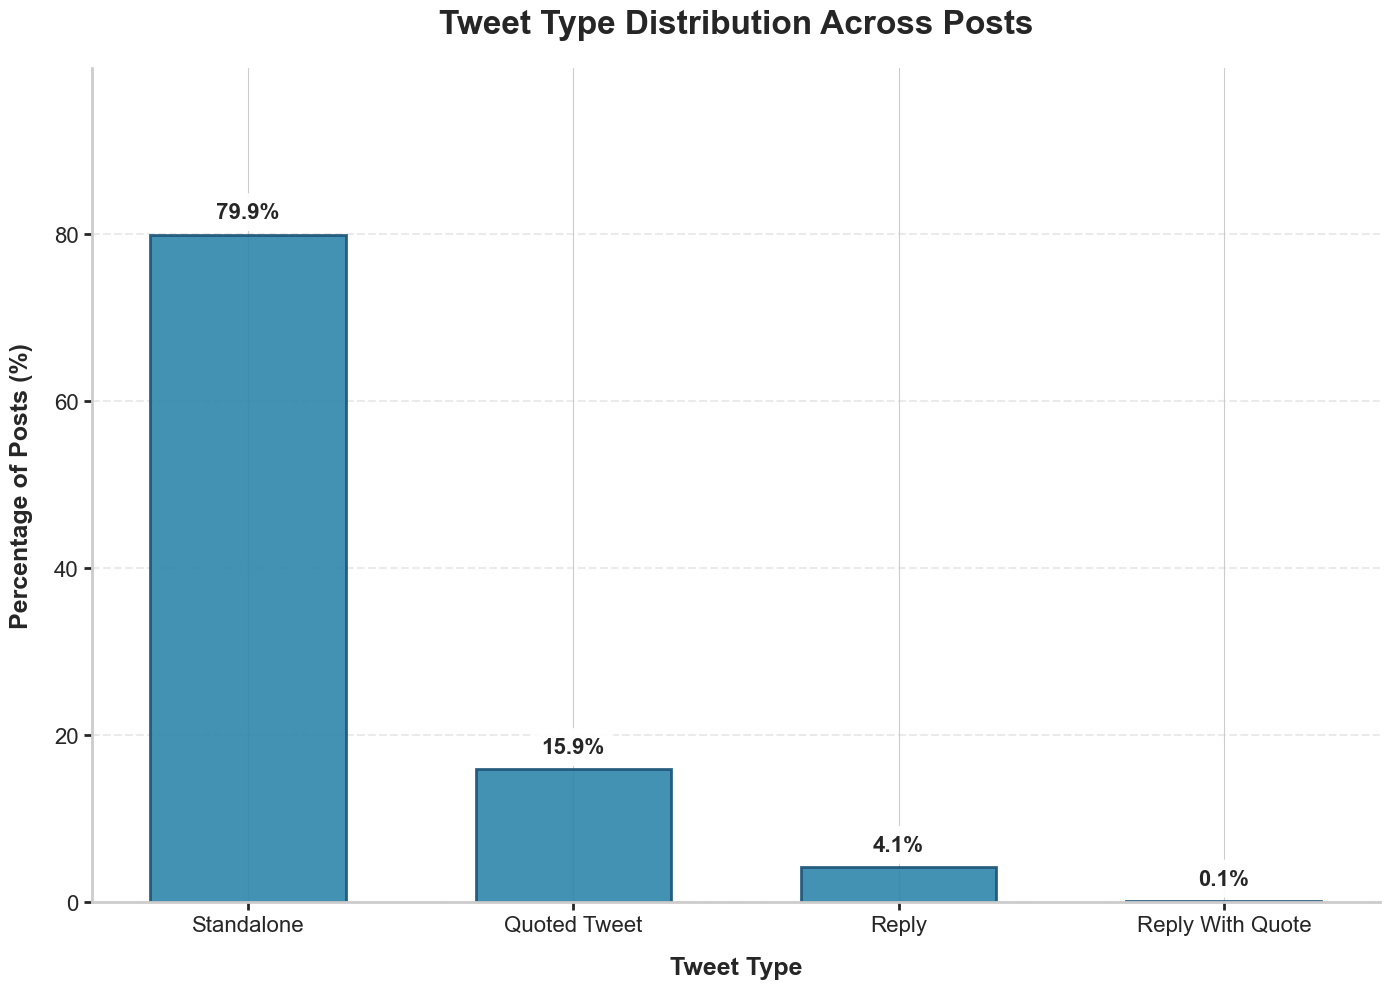

In [9]:
import matplotlib.pyplot as plt
# Tweet Type Classification Summary
conn = await asyncpg.connect(DATABASE_URL)

sql = """
WITH tweet_counts AS (
    SELECT 
        classification_data->>'value' as tweet_type,
        COUNT(*) as post_count
    FROM classifications
    WHERE classifier_slug = 'tweet-type-v1'
    GROUP BY tweet_type
),
total_posts AS (
    SELECT COUNT(DISTINCT post_uid) as total
    FROM classifications
    WHERE classifier_slug = 'tweet-type-v1'
)
SELECT 
    tc.tweet_type,
    tc.post_count,
    ROUND(100.0 * tc.post_count / tp.total, 2) as percent
FROM tweet_counts tc
CROSS JOIN total_posts tp
ORDER BY tc.post_count DESC
"""

rows = await conn.fetch(sql)
df_tweet = pd.DataFrame(rows, columns=['tweet_type', 'post_count', 'percent'])
df_tweet['tweet_label'] = df_tweet['tweet_type'].str.replace('_', ' ').str.title()

print(f"Total classified posts: {df_tweet['post_count'].sum()}")
print(f"\nTweet Type Distribution:")
df_tweet[['tweet_label', 'post_count', 'percent']]

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 10))

color = '#2E86AB'
bars = ax.bar(df_tweet['tweet_label'], df_tweet['percent'].astype(float), 
              color=color, edgecolor='#1A5276', linewidth=2, alpha=0.9, width=0.6)

ax.set_ylabel('Percentage of Posts (%)', fontsize=18, fontweight='bold', labelpad=15)
ax.set_xlabel('Tweet Type', fontsize=18, fontweight='bold', labelpad=15)
ax.set_title('Tweet Type Distribution Across Posts', fontsize=24, fontweight='bold', pad=25)
ax.tick_params(axis='both', labelsize=16, width=2, length=6)
ax.grid(axis='y', alpha=0.4, linestyle='--', linewidth=1.5)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

# Set y-axis limit to add space above bars
max_height = float(df_tweet['percent'].max())
ax.set_ylim(0, max_height * 1.25)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1.5, 
            f'{height:.1f}%', ha='center', va='bottom', 
            fontsize=16, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='none', alpha=0.95))

plt.tight_layout()
plt.show()

In [16]:
# Sankey Funnel Data Collection (Posts from 9/29/25 to 10/10/25)
from datetime import datetime

conn = await asyncpg.connect(DATABASE_URL)

start_date = datetime(2025, 9, 29)
end_date = datetime(2025, 10, 7, 23, 59, 59)

# Stage 1: Total ingested posts in date range
total_posts = await conn.fetchval("""
    SELECT COUNT(*) FROM posts 
    WHERE ingested_at >= $1 AND ingested_at <= $2
""", start_date, end_date)

# Stage 2: Fact checks - completed vs skipped
fact_checks_completed = await conn.fetchval("""
    SELECT COUNT(*) 
    FROM fact_checks fc
    INNER JOIN posts p ON fc.post_uid = p.post_uid
    WHERE fc.status = 'completed' AND p.ingested_at >= $1 AND p.ingested_at <= $2
""", start_date, end_date)

# Posts with fact checks (any status)
posts_with_fact_checks = await conn.fetchval("""
    SELECT COUNT(DISTINCT p.post_uid)
    FROM posts p
    INNER JOIN fact_checks fc ON p.post_uid = fc.post_uid
    WHERE p.ingested_at >= $1 AND p.ingested_at <= $2
""", start_date, end_date)

# Posts skipped due to video (has video but no fact check)
skipped_due_to_video = await conn.fetchval("""
    SELECT COUNT(DISTINCT p.post_uid)
    FROM posts p
    INNER JOIN classifications c ON p.post_uid = c.post_uid
    LEFT JOIN fact_checks fc ON p.post_uid = fc.post_uid
    WHERE p.ingested_at >= $1 AND p.ingested_at <= $2
        AND c.classifier_slug = 'media-type-v1'
        AND c.classification_data->'values' @> '[{"value": "has_video"}]'
        AND fc.fact_check_id IS NULL
""", start_date, end_date)

# Posts skipped due to low clarity (all other reasons - no fact check and no video)
skipped_due_to_clarity = total_posts - posts_with_fact_checks - skipped_due_to_video

# Stage 3: Notes written vs skipped by verdict type
notes_written = await conn.fetchval("""
    SELECT COUNT(*) 
    FROM notes n
    INNER JOIN fact_checks fc ON n.fact_check_id = fc.fact_check_id
    INNER JOIN posts p ON fc.post_uid = p.post_uid
    WHERE p.ingested_at >= $1 AND p.ingested_at <= $2
""", start_date, end_date)

# Notes skipped because post was TRUE (accurate)
notes_skipped_true = await conn.fetchval("""
    SELECT COUNT(*)
    FROM fact_checks fc
    INNER JOIN posts p ON fc.post_uid = p.post_uid
    LEFT JOIN notes n ON fc.fact_check_id = n.fact_check_id
    WHERE p.ingested_at >= $1 AND p.ingested_at <= $2
        AND fc.status = 'completed'
        AND fc.verdict = 'true'
        AND n.note_id IS NULL
""", start_date, end_date)

# Notes skipped because unable_to_verify or not_fact_checkable
notes_skipped_unclear = await conn.fetchval("""
    SELECT COUNT(*)
    FROM fact_checks fc
    INNER JOIN posts p ON fc.post_uid = p.post_uid
    LEFT JOIN notes n ON fc.fact_check_id = n.fact_check_id
    WHERE p.ingested_at >= $1 AND p.ingested_at <= $2
        AND fc.status = 'completed'
        AND fc.verdict IN ('unable_to_verify', 'not_fact_checkable', 'error')
        AND n.note_id IS NULL
""", start_date, end_date)

# Stage 4: Notes submitted vs not submitted (for posts in date range)
notes_submitted = await conn.fetchval("""
    SELECT COUNT(*) 
    FROM submissions s
    INNER JOIN notes n ON s.note_id = n.note_id
    INNER JOIN fact_checks fc ON n.fact_check_id = fc.fact_check_id
    INNER JOIN posts p ON fc.post_uid = p.post_uid
    WHERE p.ingested_at >= $1 AND p.ingested_at <= $2
""", start_date, end_date)
notes_not_submitted = notes_written - notes_submitted

# Stage 5: Final outcomes for submitted notes (for posts in date range)
rated_helpful = await conn.fetchval("""
    SELECT COUNT(*) 
    FROM submissions s
    INNER JOIN notes n ON s.note_id = n.note_id
    INNER JOIN fact_checks fc ON n.fact_check_id = fc.fact_check_id
    INNER JOIN posts p ON fc.post_uid = p.post_uid
    WHERE s.status = 'displayed' AND p.ingested_at >= $1 AND p.ingested_at <= $2
""", start_date, end_date)

rated_unhelpful = await conn.fetchval("""
    SELECT COUNT(*) 
    FROM submissions s
    INNER JOIN notes n ON s.note_id = n.note_id
    INNER JOIN fact_checks fc ON n.fact_check_id = fc.fact_check_id
    INNER JOIN posts p ON fc.post_uid = p.post_uid
    WHERE s.status = 'not_displayed' AND p.ingested_at >= $1 AND p.ingested_at <= $2
""", start_date, end_date)

not_enough_ratings = await conn.fetchval("""
    SELECT COUNT(*) 
    FROM submissions s
    INNER JOIN notes n ON s.note_id = n.note_id
    INNER JOIN fact_checks fc ON n.fact_check_id = fc.fact_check_id
    INNER JOIN posts p ON fc.post_uid = p.post_uid
    WHERE s.status = 'submitted' AND p.ingested_at >= $1 AND p.ingested_at <= $2
""", start_date, end_date)

print(f"Analysis Period: Posts ingested from {start_date.strftime('%m/%d/%Y')} to {end_date.strftime('%m/%d/%Y')}")
print(f"\nTotal Posts Ingested: {total_posts:,}")
print(f"\nFact Check Stage:")
print(f"  Completed: {fact_checks_completed:,}")
print(f"  Skipped - Video: {skipped_due_to_video:,}")
print(f"  Skipped - Low Clarity: {skipped_due_to_clarity:,}")
print(f"\nNote Writing Stage:")
print(f"  Written: {notes_written:,}")
print(f"  Skipped - True (accurate): {notes_skipped_true:,}")
print(f"  Skipped - Unclear: {notes_skipped_unclear:,}")
print(f"\nSubmission Stage:")
print(f"  Submitted: {notes_submitted:,}")
print(f"  Not Submitted: {notes_not_submitted:,}")
print(f"\nFinal Outcomes:")
print(f"  Rated Helpful (displayed): {rated_helpful}")
print(f"  Rated Unhelpful (not displayed): {rated_unhelpful}")
print(f"  Not Enough Ratings (submitted): {not_enough_ratings}")

await conn.close()

Analysis Period: Posts ingested from 09/29/2025 to 10/07/2025

Total Posts Ingested: 2,013

Fact Check Stage:
  Completed: 719
  Skipped - Video: 702
  Skipped - Low Clarity: 575

Note Writing Stage:
  Written: 532
  Skipped - True (accurate): 88
  Skipped - Unclear: 96

Submission Stage:
  Submitted: 100
  Not Submitted: 432

Final Outcomes:
  Rated Helpful (displayed): 14
  Rated Unhelpful (not displayed): 4
  Not Enough Ratings (submitted): 82


In [17]:
import plotly.graph_objects as go

# Calculate percentages for terminal nodes
helpful_pct = (rated_helpful / total_posts * 100) if total_posts > 0 else 0
unhelpful_pct = (rated_unhelpful / total_posts * 100) if total_posts > 0 else 0
pending_pct = (not_enough_ratings / total_posts * 100) if total_posts > 0 else 0
submission_skipped_pct = (notes_not_submitted / total_posts * 100) if total_posts > 0 else 0
note_skipped_true_pct = (notes_skipped_true / total_posts * 100) if total_posts > 0 else 0
note_skipped_unclear_pct = (notes_skipped_unclear / total_posts * 100) if total_posts > 0 else 0
fc_skipped_video_pct = (skipped_due_to_video / total_posts * 100) if total_posts > 0 else 0
fc_skipped_clarity_pct = (skipped_due_to_clarity / total_posts * 100) if total_posts > 0 else 0

# Define nodes (stages in the funnel) with counts
node_labels = [
    f"Ingested<br>{total_posts:,}",
    f"Fact Check<br>Written<br>{fact_checks_completed:,}",
    f"Skipped - Video<br>{skipped_due_to_video:,} ({fc_skipped_video_pct:.1f}%)",
    f"Skipped - Low Clarity<br>{skipped_due_to_clarity:,} ({fc_skipped_clarity_pct:.1f}%)",
    f"Note<br>Written<br>{notes_written:,}",
    f"Skipped<br>Post was true<br>{notes_skipped_true:,} ({note_skipped_true_pct:.1f}%)",
    f"Skipped<br>Fact check inconclusive<br>{notes_skipped_unclear:,} ({note_skipped_unclear_pct:.1f}%)",
    f"Note<br>Submitted<br>{notes_submitted:,}",
    f"Submission<br>Skipped<br>{notes_not_submitted:,} ({submission_skipped_pct:.1f}%)",
    f"Helpful<br>(shown)<br>{rated_helpful} ({helpful_pct:.1f}%)",
    f"Unhelpful<br>(not shown)<br>{rated_unhelpful} ({unhelpful_pct:.1f}%)",
    f"Not enough<br>ratings<br>{not_enough_ratings} ({pending_pct:.1f}%)"
]

# Define links (source -> target with value)
links = {
    'source': [
        0, 0, 0,        # Ingested -> Fact Check Written/Skipped(Video)/Skipped(Clarity)
        1, 1, 1,        # Fact Check Written -> Note Written/Skipped(True)/Skipped(Unclear)
        4, 4,           # Note Written -> Submitted/Submission Skipped
        7, 7, 7         # Note Submitted -> Outcomes
    ],
    'target': [
        1, 2, 3,        # -> Fact Check Written/Skipped(Video)/Skipped(Clarity)
        4, 5, 6,        # -> Note Written/Skipped(True)/Skipped(Unclear)
        7, 8,           # -> Submitted/Submission Skipped
        9, 10, 11       # -> Helpful/Unhelpful/Pending
    ],
    'value': [
        fact_checks_completed, skipped_due_to_video, skipped_due_to_clarity,
        notes_written, notes_skipped_true, notes_skipped_unclear,
        notes_submitted, notes_not_submitted,
        rated_helpful, rated_unhelpful, not_enough_ratings
    ],
    'color': [
        'rgba(46, 134, 171, 0.4)', 'rgba(224, 122, 95, 0.4)', 'rgba(224, 122, 95, 0.4)',  # Fact check
        'rgba(46, 134, 171, 0.4)', 'rgba(224, 122, 95, 0.4)', 'rgba(224, 122, 95, 0.4)',  # Note
        'rgba(46, 134, 171, 0.4)', 'rgba(224, 122, 95, 0.4)',  # Submission
        'rgba(34, 197, 94, 0.4)', 'rgba(239, 68, 68, 0.4)', 'rgba(156, 163, 175, 0.4)'  # Outcomes
    ]
}

fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node=dict(
        pad=25,
        thickness=15,
        line=dict(color='black', width=1),
        label=node_labels,
        color=['#1A5276', '#2E86AB', '#E07A5F', '#E07A5F', '#2E86AB', '#E07A5F', '#E07A5F',
               '#2E86AB', '#E07A5F', '#22C55E', '#EF4444', '#9CA3AF'],
        x=[0, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.75, 1, 1, 1],
        y=[0.5, 0.35, 0.65, 0.9, 0.35, 0.65, 0.9, 0.35, 0.75, 0.2, 0.5, 0.8]
    ),
    link=dict(
        source=links['source'],
        target=links['target'],
        value=links['value'],
        color=links['color']
    )
)])

fig.update_layout(
    title=dict(
        text="Community Notes Funnel: Ingestion to Outcome",
        font=dict(size=20, family='Arial, sans-serif', color='#1A1A1A')
    ),
    font=dict(size=10, family='Arial, sans-serif'),
    height=400,
    width=900,
    margin=dict(l=10, r=10, t=50, b=10)
)

fig.show()